## Прогнозирование оттока клиентов фитнес клуба

Проблема оттока клиентов не обошла и сеть фитнес-центров "Культурист-датасаентист", в то время как клиенты тихо уходят, быть может существуют факторы, по которым это возможно предсказывать и предупреждать в связи с чем необходимо совершить следующие шаги:

* научиться прогнозировать вероятность оттока;
* сформировать типичные портреты клиентов;
* проанализировать осоновные признаки, наиболее влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

[Подготовка данных.](#preparation)
 - [Описание данных](#description)
 - [Первичный анализ набора данных c информацией об отдельных столбцах.](#primary_and_more)
 - [Отличие средних в зависимости от оттока и сравнение с общим средним.](#mean_mean_mean) 
 - [Распределение признаков](#density_char)
 - [Матрица корреляции признаков](#corr_matrix)
 - [Резюмирование проделанного](#little_conclusion)
 - [Вывод](#conclusion1)

[Построение модели прогнозирования оттока клиентов](#model_manipulation)
 - [Вывод](#conclusion2)
 
[Кластеризация клиентов](#clustering)
 - [Средние значения столбцов по кластерам](#mean_clusters)
 - [Диаграммы кластеров 0 и 1, из первого отток 0.44, из второго 0.52](#clusters01)
 - [Диаграммы кластеров 2, 3 и 4, оттоки соответственно 0.27, 0.03, 0.07](#clusters123)
 - [Вывод о кластерах](#clusters_conclusion)
 
[Общий вывод](#general_conclusion)
 ## Подготовка данных.<a name='preparation'></a>

In [1]:
%%capture
!pip install seaborn -U
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
gym_churn_df = pd.read_csv('/datasets/gym_churn.csv')
gym_churn_df.columns = gym_churn_df.columns.str.lower()
gym_churn_df = gym_churn_df.round(2)
gym_churn_df.info()
gym_churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.0,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.0,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.0,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.0,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.0,3,1.11,1.12,0


### Описание данных<a name='description'></a>

Значение столбцов:
- gender — пол;
- near_location — проживание или работа в районе, где находится фитнес-центр;
- partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- phone — наличие контактного телефона;
- age — возраст;
- lifetime — время с момента первого обращения в фитнес-центр (в месяцах);
- contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
- group_visits — факт посещения групповых занятий;
- avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
- avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
- avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Первичный анализ набора данных c информацией об отдельных столбцах<a name='primary_and_more'></a>

- пропусков не обнаружено;
- некоторое количество столбцов могли бы быть булевыми, но оставим целочисленными.

In [3]:
columns_with_little_options = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period',
                               'group_visits', 'churn']
for column_name in columns_with_little_options:
    print('Соотношение различных типов клиентов по столбцу', column_name, '\n',
          gym_churn_df[column_name].value_counts() / 4000)

Соотношение различных типов клиентов по столбцу gender 
 1    0.51025
0    0.48975
Name: gender, dtype: float64
Соотношение различных типов клиентов по столбцу near_location 
 1    0.84525
0    0.15475
Name: near_location, dtype: float64
Соотношение различных типов клиентов по столбцу partner 
 0    0.51325
1    0.48675
Name: partner, dtype: float64
Соотношение различных типов клиентов по столбцу promo_friends 
 0    0.6915
1    0.3085
Name: promo_friends, dtype: float64
Соотношение различных типов клиентов по столбцу phone 
 1    0.9035
0    0.0965
Name: phone, dtype: float64
Соотношение различных типов клиентов по столбцу contract_period 
 1     0.55175
12    0.24000
6     0.20825
Name: contract_period, dtype: float64
Соотношение различных типов клиентов по столбцу group_visits 
 0    0.58775
1    0.41225
Name: group_visits, dtype: float64
Соотношение различных типов клиентов по столбцу churn 
 0    0.73475
1    0.26525
Name: churn, dtype: float64


In [4]:
other_columns = ['avg_class_frequency_current_month', 'age', 'month_to_end_contract',
                 'lifetime', 'avg_class_frequency_total', 'avg_additional_charges_total']
gym_churn_df[other_columns].describe().round(2)

,avg_class_frequency_current_month,age,month_to_end_contract,lifetime,avg_class_frequency_total,avg_additional_charges_total
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,1.77,29.18,4.32,3.72,1.88,146.94
std,1.05,3.26,4.19,3.75,0.97,96.36
min,0.00,18.00,1.00,0.00,0.00,0.15
25%,0.96,27.00,1.00,1.00,1.18,68.86
50%,1.72,29.00,1.00,3.00,1.83,136.22
75%,2.51,31.00,6.00,5.00,2.54,210.95
max,6.15,41.00,12.00,31.00,6.02,552.59


- avg_class_frequency_total - более половины клиентов посещают зал менее 2 раз в неделю;
- avg_class_frequency_current_month - за предыдущий месяц люди в среднем посещали зал реже, чем вообще, но незначительно;
- avg_additional_charges_total - 50% людей тратят на другие услуги фитнес-центра менее 137 условных единиц;
- age - медианный возраст посетителя - 29 лет, при этом самым молодым представителям - 18, а максимальный возраст - 41;
- lifetime - половина клиентов посещала фитнес-клуб менее 3 месяц до имеющихся данных;
- month_to_end_contract - у более половины людей остался месяц посещений.  

### Отличие средних в зависимости от оттока и сравнение с общим средним <a name='mean_mean_mean'></a> 

In [5]:
gym_churn_df.mean()

gender                                 0.510250
near_location                          0.845250
partner                                0.486750
promo_friends                          0.308500
phone                                  0.903500
contract_period                        4.681250
group_visits                           0.412250
age                                   29.184250
avg_additional_charges_total         146.943730
month_to_end_contract                  4.322750
lifetime                               3.724750
avg_class_frequency_total              1.879035
avg_class_frequency_current_month      1.767070
churn                                  0.265250
dtype: float64

In [6]:
gym_churn_df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445716,5.283089,4.711807,2.024917,2.027873
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082903,1.662582,0.990575,1.474939,1.044637


### Распределение признаков <a name='density_char'></a>


In [7]:
def generate_hist(name_columns, name_columns_genitive_case, query_list, array_columns, colors_set, labels, count_rows):
    fig, axs = plt.subplots(nrows = count_rows, ncols = 2, figsize=(23, 18))
    plt.subplots_adjust(wspace = 0.65, hspace=0.5)
    
    for counter in range(len(name_columns_genitive_case)):
        list_for_plot = get_difficult_list(gym_churn_df, query_list, array_columns[counter])
        axs[counter % count_rows, counter // count_rows].hist(list_for_plot, color=colors_set, alpha=0.5, label=labels)
        axs[counter % count_rows, counter // count_rows].legend()
        axs[counter % count_rows, counter // count_rows].set_title(f'Распределение клиентов в зависимости от ' \
                                    f'{name_columns_genitive_case[counter]} в совокупности с фактом ухода')
        axs[counter % count_rows, counter // count_rows].set_ylabel('Количество людей')
        axs[counter % count_rows, counter // count_rows].set_xlabel(f'{name_columns[counter]} посетителей')

    plt.show();

In [8]:
def get_difficult_list(df, query_list, column):
    result_list = []
    
    for query in query_list:
        result_list.append(df.query(query)[column])
    return result_list

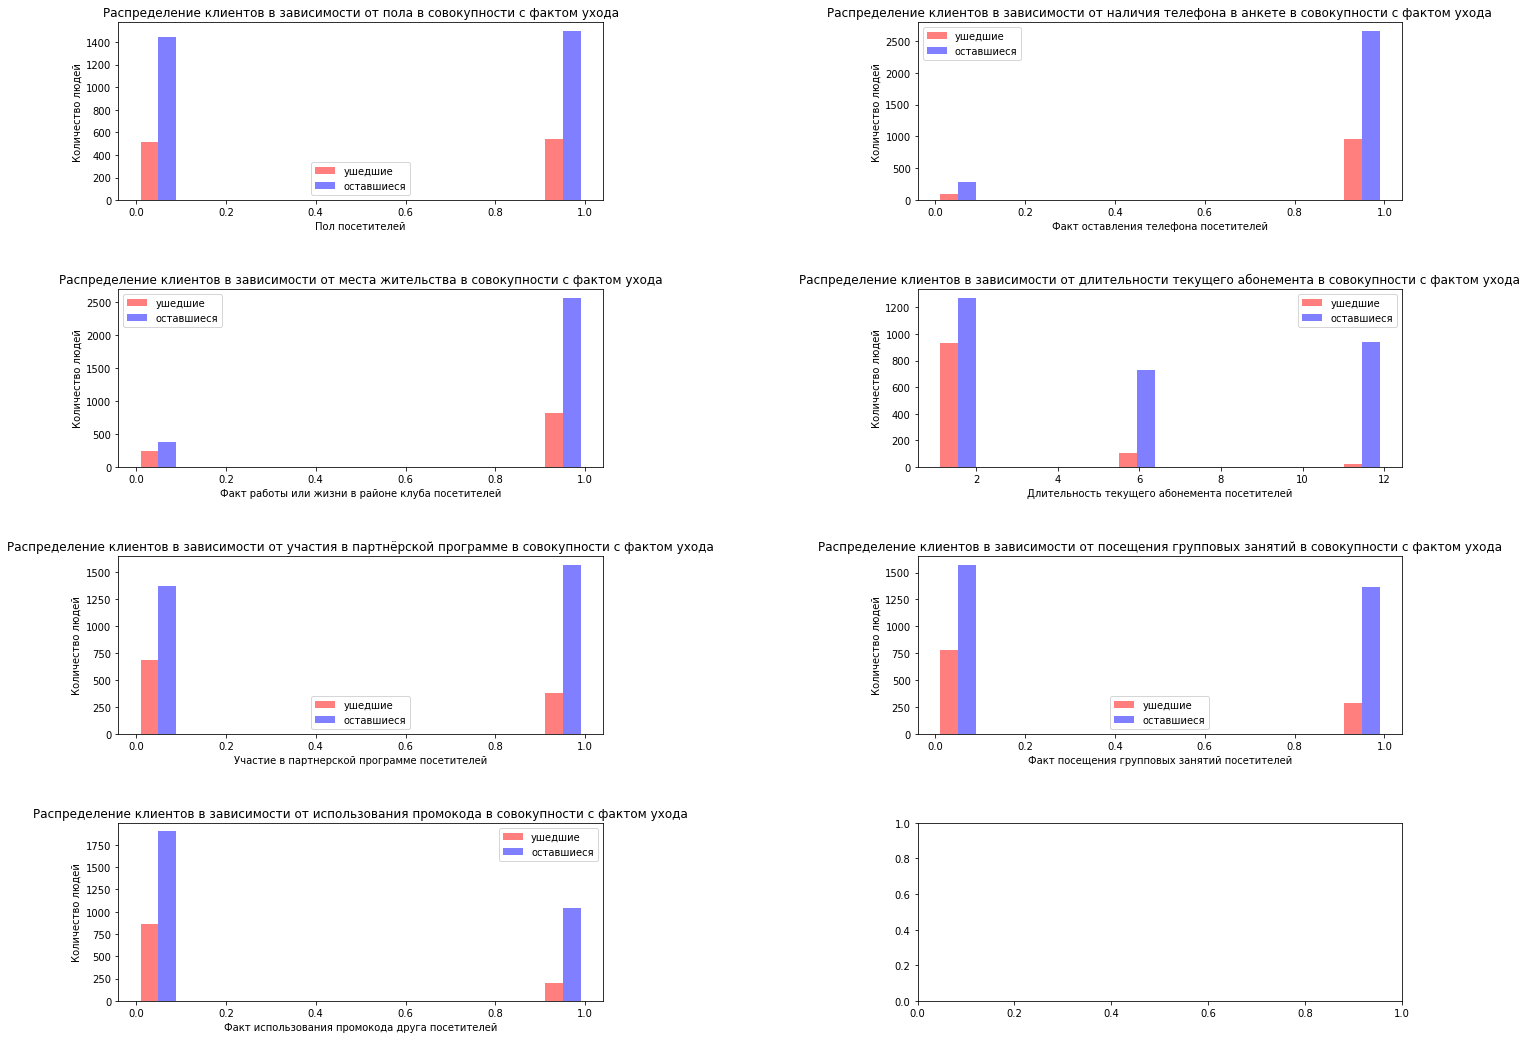

In [9]:
russian_name_columns_2_3_values = ['Пол', 'Факт работы или жизни в районе клуба', 'Участие в партнерской программе',
                        'Факт использования промокода друга', 'Факт оставления телефона', 'Длительность текущего абонемента',
                        'Факт посещения групповых занятий']
russian_name_columns_genitive_case_2_3_values = ['пола', 'места жительства', 'участия в партнёрской программе', 'использования промокода',
                        'наличия телефона в анкете', 'длительности текущего абонемента',
                        'посещения групповых занятий']

generate_hist(russian_name_columns_2_3_values, russian_name_columns_genitive_case_2_3_values, 
              ['churn == 1', 'churn == 0'], columns_with_little_options, ['r','b'], ['ушедшие', 'оставшиеся'], 4)

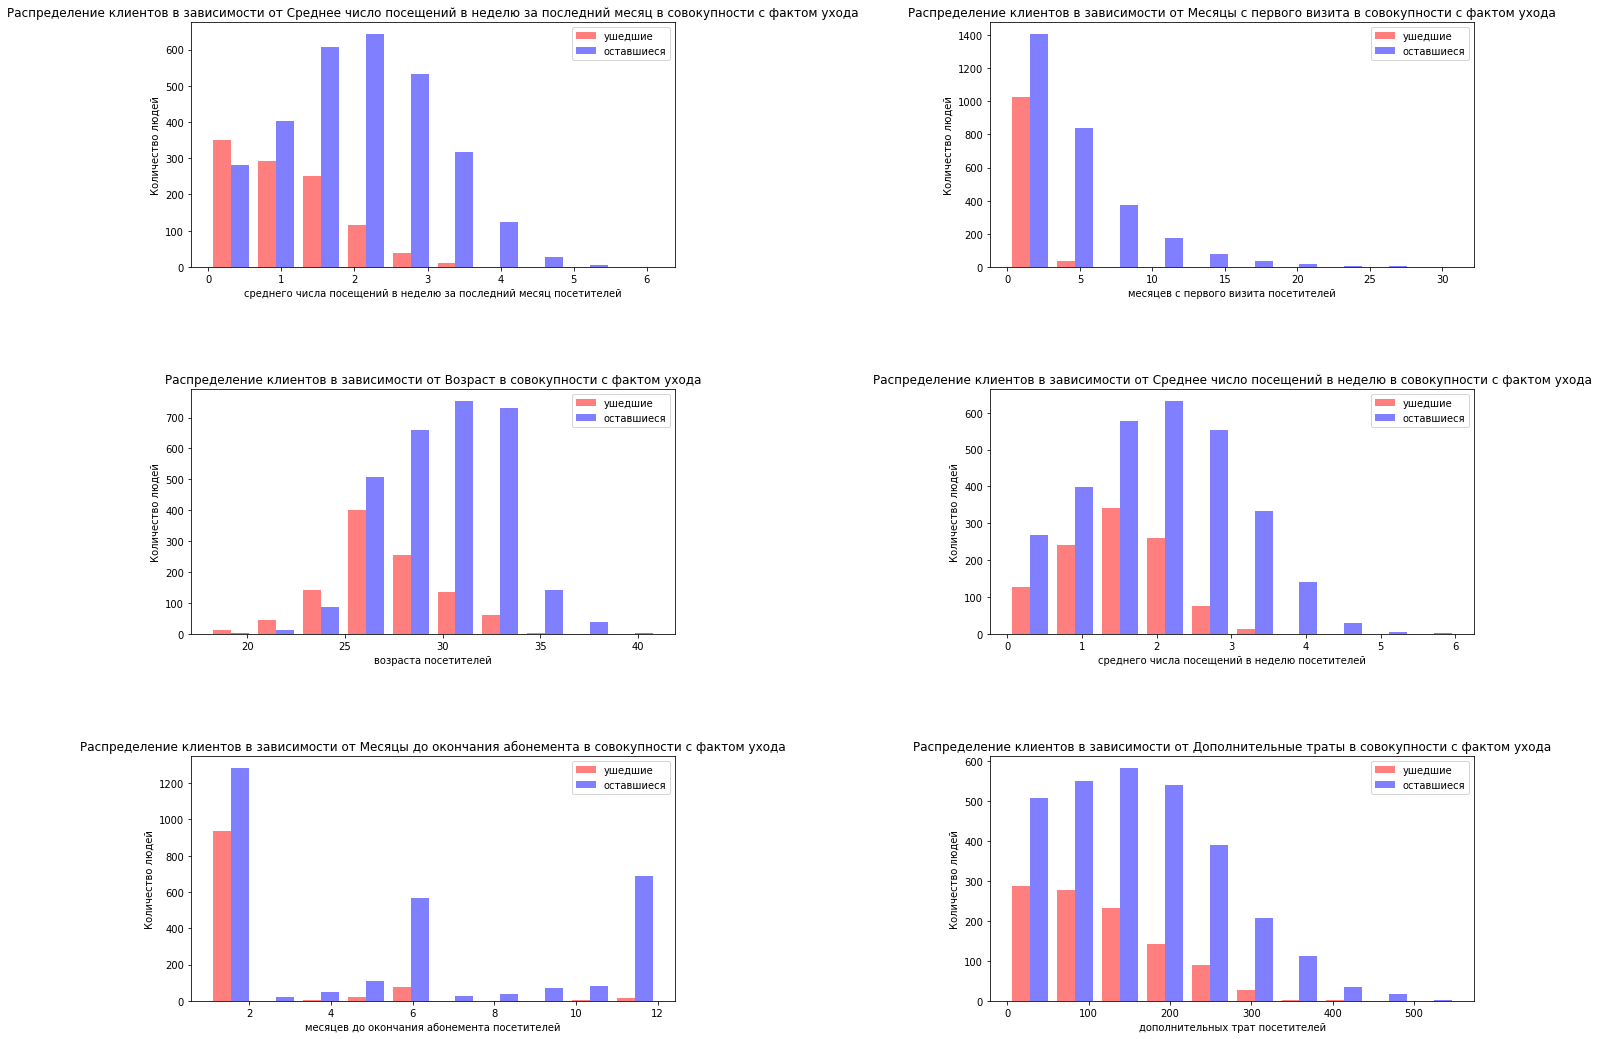

In [10]:
russian_name_columns_more2_values = ['среднего числа посещений в неделю за последний месяц', 
                                'возраста', 'месяцев до окончания абонемента','месяцев с первого визита',
                                'среднего числа посещений в неделю', 'дополнительных трат']
russian_name_columns_more2_values_genitive_case = ['Среднее число посещений в неделю за последний месяц',
                                'Возраст', 'Месяцы до окончания абонемента', 'Месяцы с первого визита',
                                'Среднее число посещений в неделю', 'Дополнительные траты']

generate_hist(russian_name_columns_more2_values, russian_name_columns_more2_values_genitive_case, 
              ['churn == 1', 'churn == 0'], other_columns, ['r','b'], ['ушедшие', 'оставшиеся'], 3)

### Матрица корреляции признаков <a name='corr_matrix'></a>

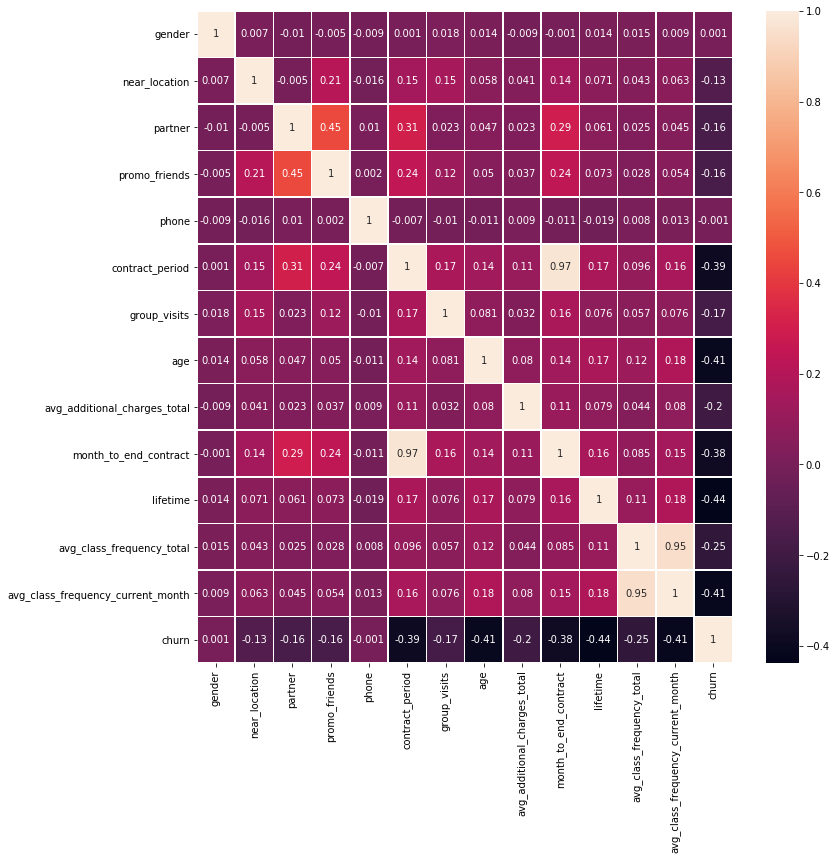

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(round(gym_churn_df.corr(), 3), annot=True, linewidths=.5);

### Вывод <a name='conclusion1'></a>

В ходе первичного анализа данных были выявлены следующие существенные отличия в столбцах группы ушедших и оставшихся:

- клиенты, у которых зал не в их районе чаще уходят;
- пользователи партнерской программы прекращают заниматься значительно реже, как и те, кто пришли по приглашению друзей;
- посещение групповых тренировок, повышает лояльность к сети;
- длительность взаимодействия с клубом, количество времени до конца абонемента стимулирует клиентов не уходить.

Обнаружены следующие факторы, корреляция с оттоком, которых менее -0.35, отсортированы по уменьшению корреляции:
- месяцев до окончания абонемента;
- длительность текущего абонемента;
- возраст;
- среднее число посещений в неделю за предыдущий месяц;
- срок сотрудничества с клубами.

## Построение модели прогнозирования оттока клиентов <a name='model_manipulation'></a>

In [13]:
X = gym_churn_df.drop(columns = ['churn'])
y = gym_churn_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [14]:
def create_train_predict_estimate(model, name_model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'Метрики модели {name_model}: \naccuracy = {accuracy_score(y_pred, y_test):.2f}\n'
          f'precision = {precision_score(y_pred, y_test):.2f}\n'
          f'recall = {recall_score(y_pred, y_test):.2f}')

In [15]:
model_log_reg = LogisticRegression(random_state=0)
create_train_predict_estimate(model_log_reg, 'логистической регрессии')

Метрики модели логистической регрессии: 
accuracy = 0.93
precision = 0.85
recall = 0.89


In [16]:
model_forest = RandomForestClassifier(random_state=0)
create_train_predict_estimate(model_forest, 'случайного леса')

Метрики модели случайного леса: 
accuracy = 0.91
precision = 0.76
recall = 0.88


### Вывод <a name='conclusion2'></a>

Некоторые признаки, например аge и аvg_additional_charges_total имеют очень разные по величине стандартные отклонения, что негативно может сказать при использовании иных методов ML, однако для логистической регрессии и дерева это не критично.

В случае с имеющимися значениями метрик имеем:
- Значения всех метрик логистической регрессии выше;
- Модель довольно точно предсказывает значения, однако в зависимости от проводимой политики важно обращать внимания и на другие метрики, если политика по удержанию клиента дорога, то стоит акцентировать внимание на precision, однако в случае борьбы за каждого посетителя стоит акцентировать внимание на увеличении recall.  

## Кластеризация клиентов <a name='clustering'></a>

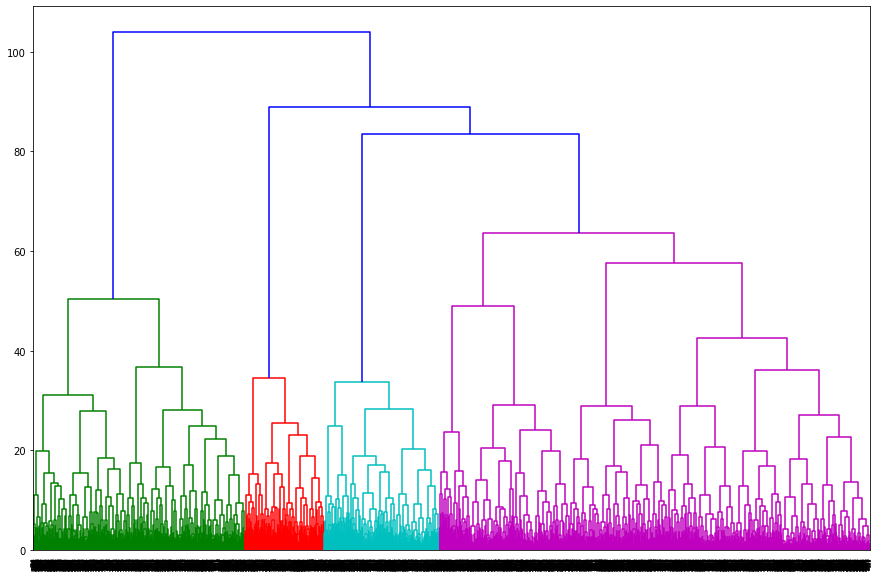

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show();

Прослеживаются пять довольно крупных, хорошо разделимых кластеров, проведём дальнейший анализ исходя из предположения, что кластеров 5.

### Средние значения столбцов по кластерам <a name='mean_clusters'></a>

In [18]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

gym_churn_df['cluster_km'] = labels
display(round(gym_churn_df.groupby('cluster_km').mean(),2))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.00,0.46,0.08,1.0,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
1,0.48,1.00,0.35,0.24,1.0,1.95,0.34,28.17,131.44,1.86,2.43,1.25,1.01,0.52
2,0.52,0.86,0.47,0.31,0.0,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
3,0.50,0.96,0.78,0.57,1.0,10.92,0.55,29.99,160.88,9.98,4.75,1.98,1.97,0.03
4,0.56,0.98,0.36,0.24,1.0,2.69,0.47,30.11,161.67,2.48,4.89,2.85,2.85,0.07


### Диаграммы кластеров 0 и 1, из первого отток 0.44, из второго 0.52 <a name='clusters01'></a>

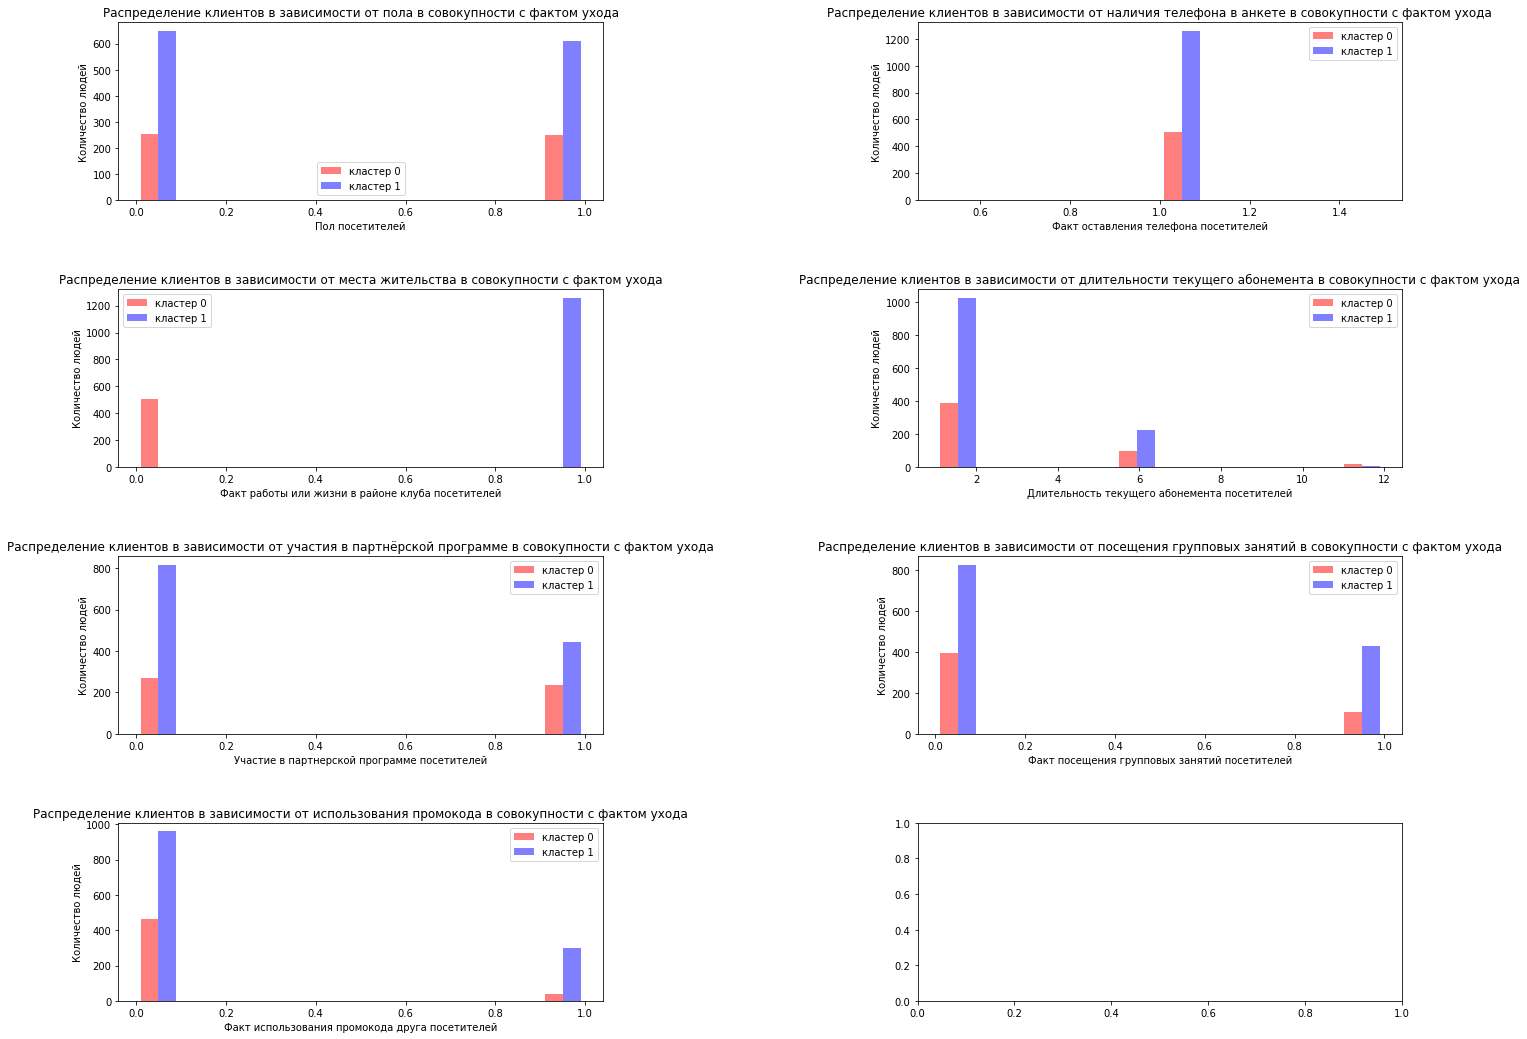

In [19]:
generate_hist(russian_name_columns_2_3_values, russian_name_columns_genitive_case_2_3_values, 
              ['cluster_km == 0', 'cluster_km == 1'], columns_with_little_options, ['r','b'], ['кластер 0', 'кластер 1'], 4)

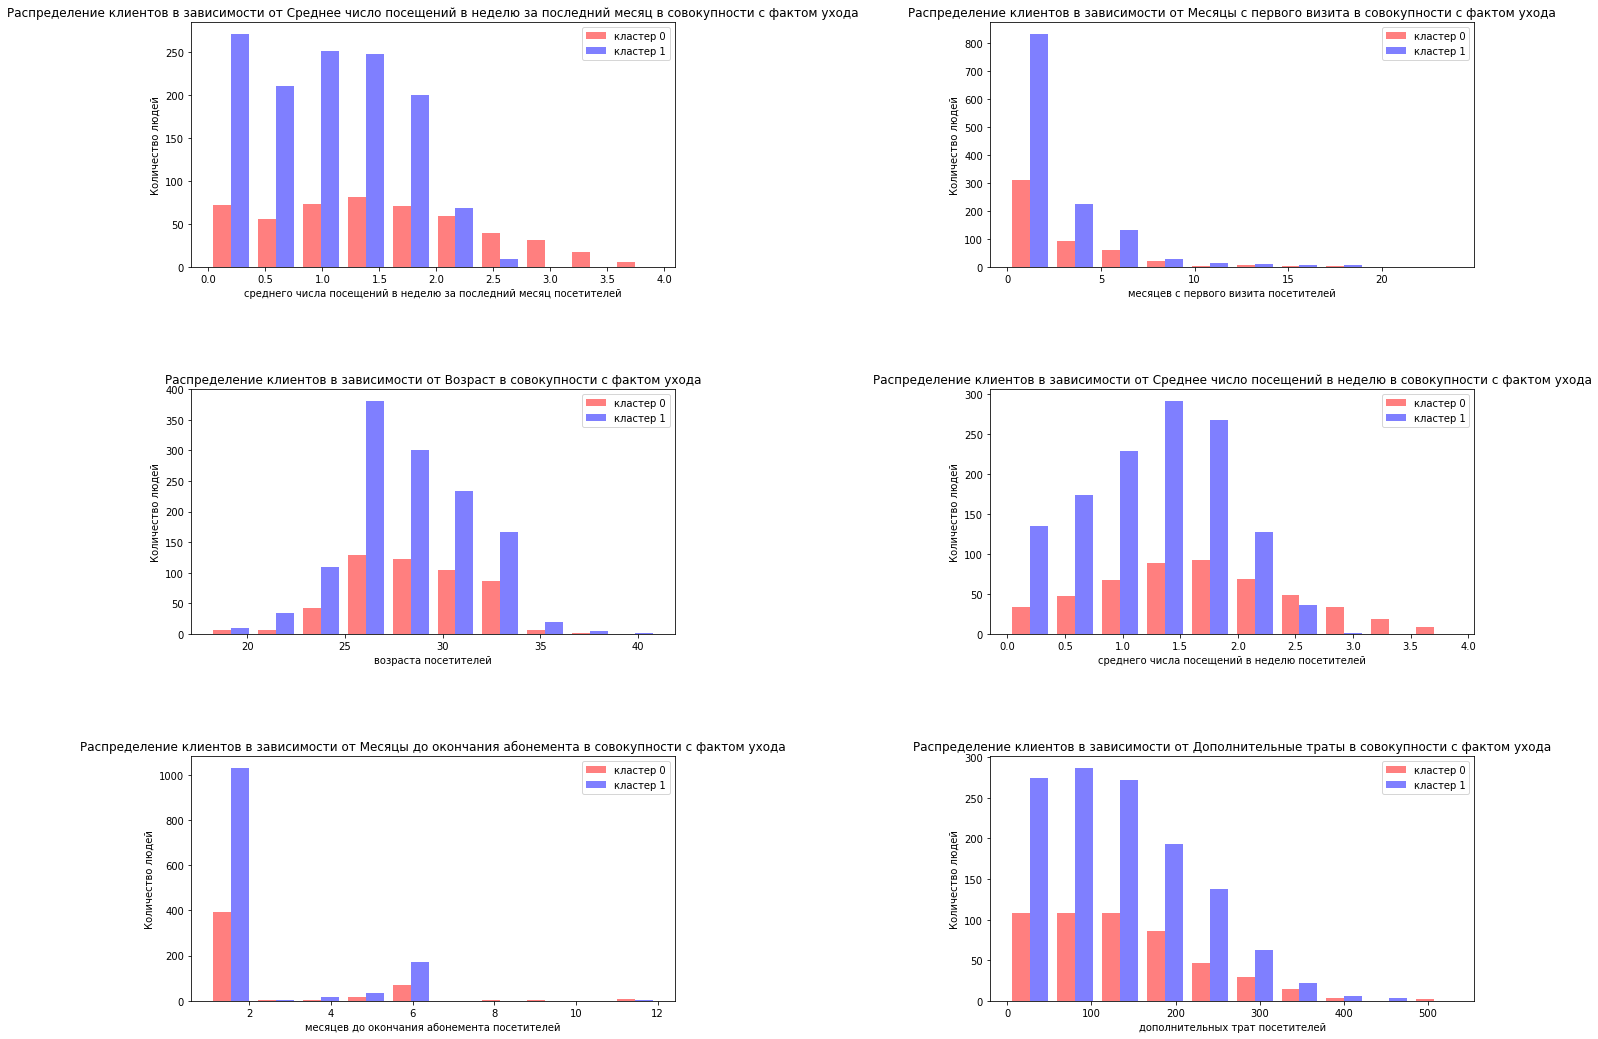

In [20]:
generate_hist(russian_name_columns_more2_values, russian_name_columns_more2_values_genitive_case, 
              ['cluster_km == 0', 'cluster_km == 1'], other_columns, ['r','b'], ['кластер 0', 'кластер 1'], 3)

### Диаграммы кластеров 2, 3 и 4, оттоки соответственно 0.27, 0.03, 0.07 <a name='clusters123'></a>

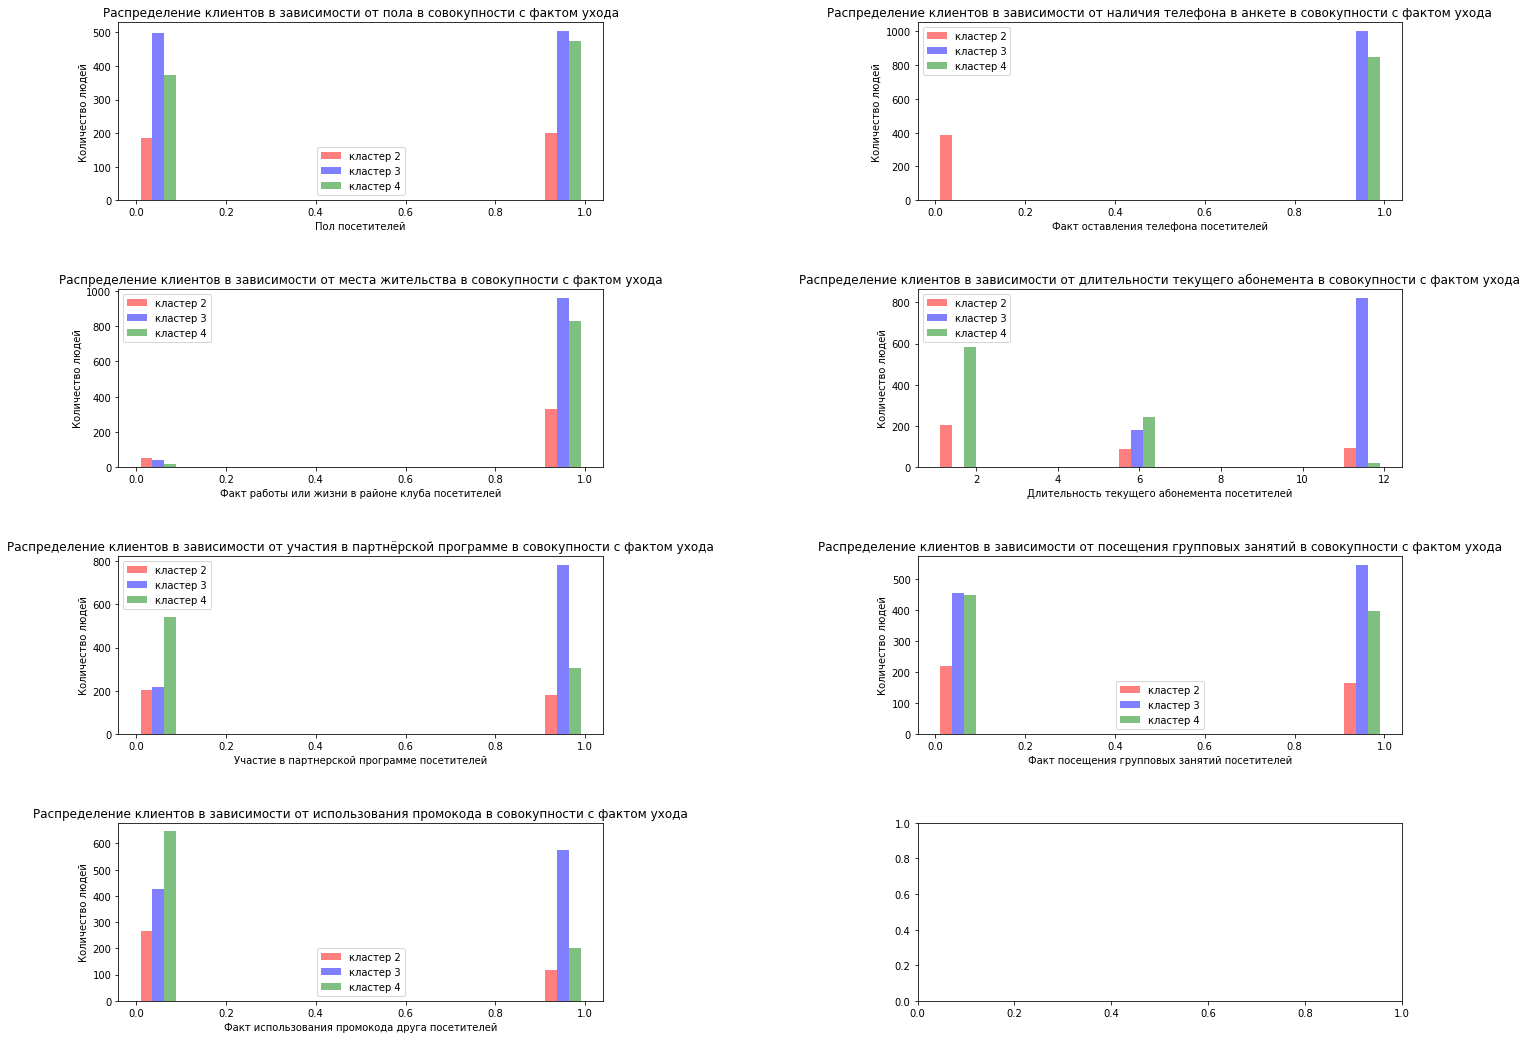

In [21]:
generate_hist(russian_name_columns_2_3_values, russian_name_columns_genitive_case_2_3_values, 
              ['cluster_km == 2', 'cluster_km == 3', 'cluster_km == 4'],
              columns_with_little_options, ['r', 'b', 'g'], ['кластер 2', 'кластер 3', 'кластер 4'], 4)

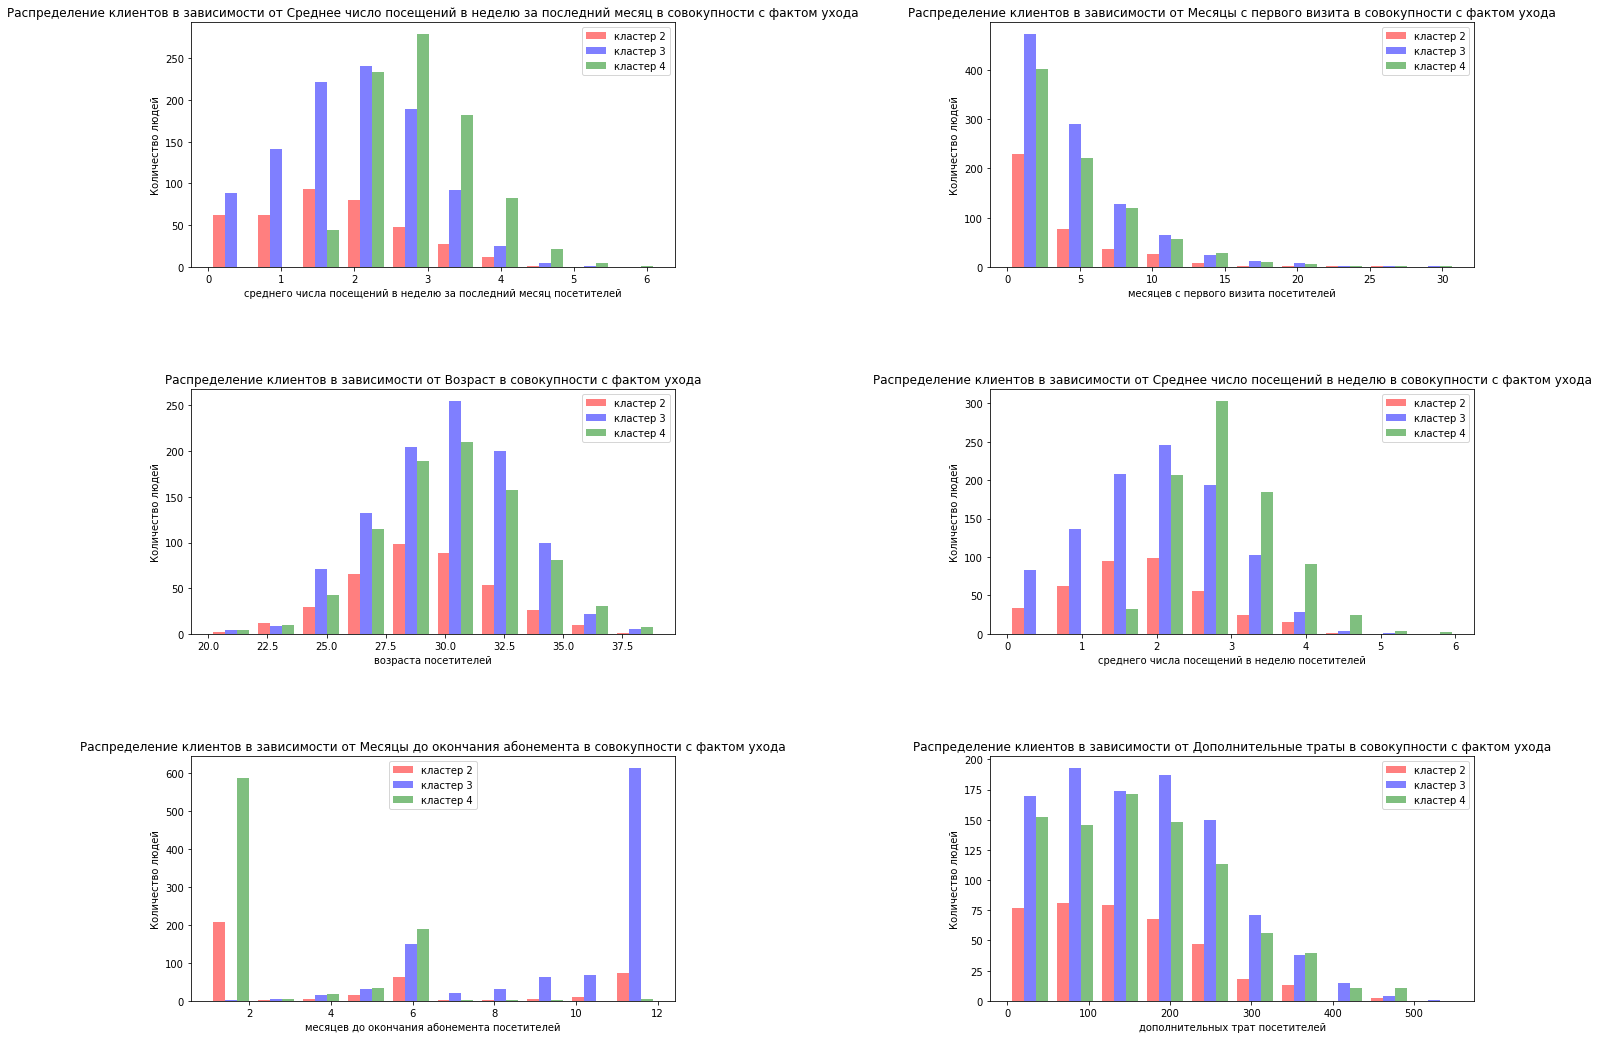

In [22]:
generate_hist(russian_name_columns_more2_values, russian_name_columns_more2_values_genitive_case, 
              ['cluster_km == 2', 'cluster_km == 3', 'cluster_km == 4'],
              other_columns, ['r', 'b', 'g'], ['кластер 2', 'кластер 3', 'кластер 4'], 3)

### Вывод о кластерах <a name='clusters_conclusion'></a>
Получены пять кластеров, в двух из которых наблюдается существенный отток 0.44, 0.52, также были получены кластеры со следующими средними оттоками 0.27, 0.03, 0.07, рассмотрим различия в кластерах:

Сравнение средних в различных кластерах:
- факторы характерные группам с малым оттоком:
   - высокая вовлечённость в групповые тренировки;
   - связь с клубом длиннее 4 месяцев;
   - среднее число посещений в неделю более 2 раз;
   - возраст более 29 лет;
   - суммарная выручка от других услуг более 160 единиц.

- факторы, наблюдаемые в одной из групп с малым оттоком:
   - участие партнерской программой;
   - первоначальная записи в рамках акции «приведи друга»;
   - длительный остаток абонемента.
 

## Общий вывод  <a name = 'general_conclusion'></a>

В ходе первичного анализа данных были выявлены следующие существенные отличия в столбцах группы ушедших и оставшихся:

- клиенты, у которых зал не в их районе чаще уходят;
- пользователи партнерской программы прекращают заниматься значительно реже, как и те, кто пришли по приглашению друзей;
- посещение групповых тренировок, повышает лояльность к сети;
- длительность взаимодействия с клубом, количество времени до конца абонемента стимулирует клиентов не уходить.

Обнаружены следующие факторы, корреляция с оттоком, которых менее -0.35, отсортированы по уменьшению корреляции:
- месяцев до окончания абонемента;
- длительность текущего абонемента;
- возраст;
- среднее число посещений в неделю за предыдущий месяц;
- срок сотрудничества с клубами.

При более пристальном рассмотрении были обнаружены следующие факторы:
- факторы характерные группам с малым оттоком:
   - высокая вовлечённость в групповые тренировки;
   - связь с клубом длиннее 4 месяцев;
   - среднее число посещений в неделю более 2 раз;
   - возраст более 29 лет;
   - суммарная выручка от других услуг более 160 единиц.


- факторы, наблюдаемые в одной из групп с малым оттоком:
   - участие партнерской программой;
   - первоначальная записи в рамках акции «приведи друга»;
   - длительный остаток абонемента.


Исходя из наблюдений, изложенных выше рекомендую принимать следующие действия:
- дополнительно увлекать клиентов социальной причастностью: участие в промо-акции «приведи друга», расширение сотрудничающих компаний, вовлечение в групповые тренировки;
- увеличивать срок и частоту взаимодействия с клиентами, выгодные абонементы длиннее 4 месяцев и частотой более 2 раз в неделю; 
- акцентирование внимания на людях возраста более 29 лет.